In [1]:
import os
import torch
import random
from tqdm import tqdm
from IPython.display import clear_output

In [2]:
if not (os.path.exists('/content/ijcnlp_dailydialog.zip') and os.path.exists('/content/ijcnlp_dailydialog')):
  print('dowloading...')
  !wget http://yanran.li/files/ijcnlp_dailydialog.zip
  !unzip /content/ijcnlp_dailydialog.zip
else:
  print('files already exists')

if not (os.path.exists('/content/data/test') and os.path.exists('/content/data/train') and os.path.exists('/content/data/validation')):
  !mkdir data
  !unzip /content/ijcnlp_dailydialog/validation.zip -d /content/data
  !unzip /content/ijcnlp_dailydialog/train.zip -d /content/data
  !unzip /content/ijcnlp_dailydialog/test.zip -d /content/data
else:
  print('files already exists')

!rm /content/ijcnlp_dailydialog.zip
!rm -r /content/ijcnlp_dailydialog

clear_output(wait=False)

In [3]:
!pip install transformers==4.38.2
clear_output(wait=False)

In [4]:
from transformers import RobertaModel, RobertaTokenizer
encoder = RobertaModel.from_pretrained('roberta-base')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
clear_output(wait=False)
print(tokenizer.pad_token_id)

1


In [5]:
from google.colab import drive
drive.mount("Mydrive")

Drive already mounted at Mydrive; to attempt to forcibly remount, call drive.mount("Mydrive", force_remount=True).


In [6]:
class CustomDataset():

    def __init__(self, data_path, tokenizer, batchsize, maxlength) -> None:
        self.data = open(data_path)
        self.tokenizer = tokenizer
        self.batchsize = batchsize
        self.maxlength = maxlength
        self.data = self.custom_dataset()

    def custom_dataset(self):
        data = []
        for line in self.data:
            seqs = line.split('__eou__')
            seqs = ''.join(seqs)
            data.append(seqs)
        self.length = len(data)//self.batchsize
        return data

    def __len__(self):
        return self.length

    def batch_tokenize(self, texts):
        token_ids_batch, token_mask_batch = [], []
        # add start token
        for text in texts:
            encoded = self.tokenizer(text,
                      truncation = True,
                      padding="max_length",
                      max_length = self.maxlength,
                      return_tensors="pt")
            token_ids_batch.append(encoded)
        return token_ids_batch

    def load_batch(self, shuffle=True):
        data = self.custom_dataset()
        if shuffle:
            random.shuffle(data)

        for i in range(0, len(data), self.batchsize):
            batch_texts = data[i:i+self.batchsize]
            yield self.batch_tokenize(batch_texts)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
class Model(nn.Module):
    def __init__(self, encoder, vocab_size) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder_layer = nn.Linear(768, vocab_size)

    def forward(self, x, mask):
        embeddings = self.encoder(input_ids=x, attention_mask=mask)
        embedding = embeddings.last_hidden_state
        return self.decoder_layer(embedding)

model = Model(encoder, tokenizer.vocab_size).to(device)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
dataset = CustomDataset("/content/data/train/dialogues_train.txt", tokenizer, 4, 512)

In [10]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [11]:
teacher_model = Model(encoder, tokenizer.vocab_size).to(device)
pretrained_state_dict = torch.load("/content/Mydrive/MyDrive/18786 Project/Results/big_model")
teacher_model.load_state_dict(pretrained_state_dict)
teacher_model.eval()
clear_output(wait=False)

In [12]:
import torch
import torch.nn as nn

import torch.nn.functional as F

from torch.nn import Transformer
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class EmbeddingLayer(nn.Module):
    def __init__(self, d_model, vocab_size, max_lens, device="cuda", dropout=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout_layer = nn.Dropout(dropout)
        self.embedding_layer = nn.Embedding(vocab_size, d_model)
        self.positional_enoc = nn.Parameter(torch.zeros(1, max_lens, d_model)).to(device)

    def forward(self, x):
        embedding = self.layer_norm(self.embedding_layer(x))
        return self.dropout_layer(embedding + self.positional_enoc[:, :x.size(1), :])


class Vanilla_Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, n_head, dim_feedforward, num_layers, max_lens, device="cuda", dropout=0.1) -> None:
        super().__init__()
        self.embedding_layer = EmbeddingLayer(d_model, vocab_size, max_lens, device)
        encoder_layer = TransformerEncoderLayer(d_model, n_head, dim_feedforward, batch_first=True)
        self.encoder = TransformerEncoder(encoder_layer, num_layers)
        self.output_layer = nn.Linear(d_model, vocab_size)
        self.dropout_layer = nn.Dropout(dropout)
        self.device = device

    def get_causal_mask(self, seq_len, device):
        return Transformer.generate_square_subsequent_mask(sz=seq_len, device=device)

    def forward(self, x, src_padding_mask=None):
        embedding = self.embedding_layer(x)
        mask = self.get_causal_mask(x.size(1), device=self.device)
        encoded_embedding = self.encoder(src=embedding, mask=mask,
                          src_key_padding_mask=src_padding_mask, is_causal=True)
        output = self.output_layer(encoded_embedding)
        return self.dropout_layer(output)


vocab_size, d_model, n_head, dim_feedforward, num_layers, max_lens = tokenizer.vocab_size, 512, 8, 2048, 4, 512
student_model = Vanilla_Transformer(vocab_size, d_model, n_head, dim_feedforward, num_layers, max_lens).to(device)

In [13]:
def validation(model, dataset, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for data_point in tqdm(dataset.load_batch(), total=dataset.length, leave=True):
            for j in range(len(data_point)):
                if j == 0:
                    x, mask = data_point[j]['input_ids'].to(device), data_point[j]["attention_mask"].to(device)
                else:
                    x, mask = torch.cat([x, data_point[j]['input_ids'].to(device)], dim=0), torch.cat([mask, data_point[j]["attention_mask"].to(device)], dim=0)

            src = x[:, :-1]
            tgt = x[:, 1: ]
            bool_mask = ~ mask.to(torch.bool)
            float_mask = bool_mask.to(torch.float)
            float_mask = float_mask.masked_fill(bool_mask, float('-inf'))
            output = model(src, float_mask[:, :-1])
            loss = criterion(output.transpose(1,2), tgt)
            epoch_loss += loss.item()
        epoch_loss = epoch_loss/(dataset.length)
    return epoch_loss

In [14]:
import gc
torch.cuda.empty_cache()
gc.collect()

34

In [15]:
def distillation_loss(student_logits, teacher_logits, temperature=1):
    student_probs = torch.nn.functional.softmax(student_logits / temperature, dim=-1)
    teacher_probs = torch.nn.functional.softmax(teacher_logits / temperature, dim=-1)
    # return torch.nn.functional.kl_div(student_probs.log(), teacher_probs, reduction='batchmean')
    return torch.nn.functional.kl_div(teacher_probs.log(), student_probs, reduction='batchmean')

epoch = 80
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = torch.optim.AdamW(student_model.parameters(), lr=1e-4)
dataset = CustomDataset("/content/data/train/dialogues_train.txt", tokenizer, 24, 512)
validationset = CustomDataset("/content/data/validation/dialogues_validation.txt", tokenizer, 1, 512)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5, last_epoch=-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, threshold=0.001)
# please exploring these parameters: epoch, lr, scheduler(step_size, gamma), (num_layer, d_model, n_head, dim_feedforward), batch_size
# size of (num_layer=6, d_model=512, n_head=8, dim_feedforward=2048)->153 MB, please don't test model larger than this one
train_loss = []
valid_loss = []
for i in range(epoch):
    e_loss = 0
    student_model.train()
    # teacher_model.eval()
    for data_point in tqdm(dataset.load_batch(), total=dataset.length, leave=True):
        optimizer.zero_grad()
        for j in range(len(data_point)):
            if j == 0:
                x, mask = data_point[j]['input_ids'].to(device), data_point[j]["attention_mask"].to(device)
            else:
                x, mask = torch.cat([x, data_point[j]['input_ids'].to(device)], dim=0), torch.cat([mask, data_point[j]["attention_mask"].to(device)], dim=0)

        src = x[:, :-1]
        tgt = x[:, 1: ]
        bool_mask = ~ mask.to(torch.bool)
        float_mask = bool_mask.to(torch.float)
        float_mask = float_mask.masked_fill(bool_mask, float('-inf'))
        student_logits = student_model(src, float_mask[:, :-1])
        # with torch.no_grad():
        #     teacher_logits = teacher_model(src, mask[:, :-1])

        primary_loss = criterion(student_logits.transpose(1, 2), tgt)
        # distillation_losses = distillation_loss(student_logits, teacher_logits)
        loss = primary_loss
        loss.backward()
        optimizer.step()
        e_loss += loss.item()

    e_loss = e_loss/(dataset.length)
    v_loss = validation(student_model, validationset, criterion)
    print(e_loss)
    print(v_loss)
    print('tgts: {}'.format(tokenizer.decode(tgt[0].tolist())))
    print('pred: {}'.format(tokenizer.decode(torch.argmax(student_logits, dim=-1)[0].tolist())))
    print("epoch: {}".format(i))
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {i + 1}, Current Learning Rate: {current_lr}")
    train_loss.append(e_loss)
    valid_loss.append(v_loss)
    scheduler.step(v_loss)

464it [04:56,  1.56it/s]
100%|██████████| 1000/1000 [01:02<00:00, 15.92it/s]


5.871040869480075
4.454246862649917
tgts: You had better get a grab instead of getting upset about little things.  I know. But my life seems super stressful. I really don ’ t know how to get a better grab on things.  I think as long as you try your best and don ’ t think of anything too much, everything will be all right. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 15.92it/s]


5.0499787289432
4.142338726282119
tgts: I'm terribly nervous.  Calm down! 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 15.92it/s]


4.830093278740704
3.946026667356491
tgts: Broadway Mall is having a big sale this weekend. You wanna go?  Don't feel like it. I'm broke.  Well, we can still do some window shopping, can't we?  Just look around? Ah, that's boring.  I'll go myself then. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 15.90it/s]


4.677460402700865
3.8189951786994936
tgts: I want to check out today. My plane leaves at 3 p. m.  Which room are you staying in now, sir?  I am in Room 205. My name is Bill Smith. When shall I check out?  Usually if you are leaving today, you'd better check out before 12 noon, and leave the room. If you check out after 12 noon, we will count one day more.  Oh, I didn't know that.  Since your plane leaves at 3 p. m. it will be too early for you to leave the hotel at 12 0'clock. We can arrange you to stay in the room until 1 p. m. ; but first you should still check out before 12 noon.  That's very considerate of you. May I have my bill?  Yes, sir. Here it is.  How much is it?  Your bill comes to 60 dollars. How would you like it to be paid? With cash or credit card?  I'd like it to be charged to my credit card.  Would you please give to me, and will imprint it? 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 15.90it/s]


4.555235088257759
3.72003238260746
tgts: The whether in Beijing is just beautiful.  Autumn is the best season in Beijing you know?  Yes. I can see. The summer heat is over. And the winter cold is still far away.  What is the whether like in Washington at this time of this year?  Autumn is also very nice In Washington.  Is it very cold in winter there?  No. it isn ’ t. But sometimes it slows a lot in winter.  Does it rain a lot in summer there?  Oh. Yes. Sometimes it rains very heavily  How about here in Beijing?  There ’ s a lot of rain in summer. But it seldom rains in autumn  I feel it ’ s rather dry here  That ’ s true. many people from the south don ’ t like the whether here.  Are you from south?  No. I ’ m from the north. I was born in Beijing actually.  I see. So this is your hometown? 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 15.91it/s]


4.45276767955228
3.6311207106113432
tgts: I don't know, but he gives me the creeps.  Just take it easy. If he starts to bother you, let me know and I'll call security.  But what if he knows my name, where I live...  Don't get all worked up over him. He's probably harmless.  Actually, he's really good-looking. Too bad he's a weirdo.  You never know. Maybe he's just an innocent, lonely guy...  Now he's looking over here! He's coming!  OK! I'll call security. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 15.91it/s]


4.35516245679258
3.579994251012802
tgts: Are you excited about your trip next month?  Yes and no. I can't wait to go to Europe, but at the same time I am terrified.  Why?  Well, I have acrophobia. I have a chronic fear of flying.  Oh really? I have an uncle who is also terrified of flying. It's not that bad though, I mean, it is pretty scary to be in this big machine flying through the air at seven hundred miles per hour. I actually have arachnophobia.  You're scared of spiders? I actually have two more phobias. Acrophobia and glossophobia.  I guess that explains why you are afraid of flying, but public speaking is not that bad.  Are you kidding? When I get on stage, my palms start to sweat, I get really nervous and I can hardly speak.  Well, I must confess I am a bit claustrophobic. I hate being in an elevator for more than 5 seconds.  We are such weirdos right? 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 15.92it/s]


4.269776770672067
3.5135148837566375
tgts: We will go to climb up the hill tomorrow. Let's go to supermarket to buy some food.  Yes, we can have a picnic on the top of the hill.  What should we buy?  Let me see. We should go to buy some fruit first.  It is heavy and not convenient to take them to the top.  How about taking a cantaloupe? It is light and sweet. Children love it.  Good idea. We can buy some candy and nuts for children.  Yes. Look, cashew, peanuts, assorted biscuits, chocolate, canned goods, anything else?  That's enough for the kids. Get some drinks.  Definitely beer. Two bottles.  Right. We should buy some yoghurt for kids.  Yes. Shall we buy some saucers? It will be used during our picnic.  OK. Four saucers. We can buy some custard tarts tomorrow morning.  Let's go to queue up. There are so many people in the lines. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 15.93it/s]


4.192163334037006
3.4610782128572466
tgts: You spoken English is pretty good. Please tell me your experience in learning English.  Uh, I don't know what to say. What do you want to know?  What's your method of learning?  Let me think a minute. I think I always try to take every chance to practice.  What if there is no chance? I mean what if you don't have a partner, what will you do?  Well, I talk to myself. That is, I play one role first, than the other.  That's a good idea. You are really creative. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 15.92it/s]


4.120898118029403
3.4121095916032793
tgts: Which department do you want to register with?  I want to see a dentist.  Please pay the registration fee, 10 Yuan.  OK, thank you. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 15.91it/s]


4.04901822287887
3.369183715581894
tgts: How may I help you?  I need to return these books.  What happened to this one?  The cover came off.  You ’ re going to need to pay for the damage.  How much are you talking?  It ’ s going to be $ 5.  That ’ s not bad at all.  It really isn ’ t.  Here you go.  Thank you very much.  You ’ re welcome. Have a nice day. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 15.92it/s]


3.9806420906058655
3.336817655324936
tgts: I've brought a little dog for Alice, girls usually like looking after pets.  Thank you, but Alice is only a visitor here. I don't know if she'll keep it.  To tell you the truth, the dog isn't my real reason for coming. I want to ask Alice if she'd like to be my girlfriend.  Really? 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 15.91it/s]


3.918281267837623
3.307218185067177
tgts: You look really wiped out?  I had meetings back to back all morning. And phone rang off the hook from the minute I walked into the office.  Not a good day. I hate to tell you that Mr. Thomas wants to see the profit ’ s statement for new project tomorrow morning.  I can ’ t believe it. I guess I ’ ll be here until 10 again tonight. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 15.91it/s]


3.8548588639459136
3.2718092926740647
tgts: Hi, Mary. I haven't seen you in ages! I heard that you and Daniel are getting married on August 8th, the opening day of the 2008 Olympic Games. Is it true?  yes, it is. We've been dating for over 7 years. We have decided to get married on a special day and we think August 8th, 2008 is a red-letter day.  good for you! It sounds like you've done a lot of planning in a very short time.  yes, there is a lot of to be taken care of---wedding photos, wedding dress, catering, transport, hotel, etc...  is everything ready now?  almost. The only thing that isn't ready is the hotel. As a lot of people have chosen that day to get married, it is hard to find a hotel that isn't too expensive.  have you tried The Peninsula Palace Beijing? My wedding reception was held there and they did an excellent job.  yes, we called, but it is booked up. The only choice is the Regent Beijing but we haven't made up our minds yet.  it's an excellent hotel. A friend of min

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 15.91it/s]


3.798569057724131
3.245593977332115
tgts: Hello. Excuse me. Do you know if there's a Commercial Bank around here?  Yes, go straight along Beijing Road and turn right.  Straight on, and turn right. Is it far?  No, it's just a couple of minutes.  Thanks very much.  You're welcome. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 15.93it/s]


3.745312508445064
3.2338903489112854
tgts: So Peter, do you have a favorite comedy?  Well, that's hard to say because there are so many good ones. I don't think I could pick a favorite.  You know what comedy I really like? " Ace Ventura, Pet Detective. " I think Jim Carry is really funny.  Oh yeah, that's one of my favorite flicks. I think Jim Carry is one of the funniest comedians ever.  I agree. But even though I like comedies, I usually prefer more serious films. My favorite movie is " Titanic. " 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 15.91it/s]


3.6918714643812076
3.2096416912078856
tgts: I've been chosen to plan the next family reunion.  Fun for you! Do you get to do anything you want?  Yep. And I should start planning now.  Does everyone usually show up for your family reunions?  Just about. There are at least a few hundred in our immediate family alone.  How Ay days will the reunion be?  Usually it's at least five days and four nights.  This is going to be a major production for you! 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.12it/s]


3.638101317197664
3.1928718234300613
tgts: Come on, Let's go for lunch, Gregory.  I was going to eat in, I'm short on cash.  Don't worry about it.It's on me.  In that case, I'm with you. Em.this is good.  I agreed, Hi, guess what? I went bungee jumping last weekend.  Are you on the up and up?  Definitely. you know, I'm into serious sport in a big way.  If you asked me, you've got a screw loose somewhere.  come off it, It's not that serious. You should DIY ( do it yourself ) sometime.  Fat chance, I'm too scared of bungee jumping.  No, really, I think you'd like it. I adapted to it right off the bat.  What did that have to do with me? I'm not the self-seeker like you.  I can teach you how.  I had a sneaking suspicion about you, Eric, I think you've lost it.  No, not really, but I think I have lost my wallet. Where can it be? 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.13it/s]


3.5894023285571235
3.1824984246492387
tgts: There's so much to do and so little time.  I know. Did your mom double check on the church reservations?  Yes. We're going to be married in my hometown church, the first minute of the new millennium!  OK... and what about the buffet and the cake? Did your mom call the caterer?  All set. And we're having a red bean cake and dim sum for the Taiwanese guests, just like your mom wanted.  Great. She'll be so happy. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.13it/s]


3.5346604701509743
3.15872850215435
tgts: You didn't come to work yesterday.What happened?  I had to look after my son at home.  What's wrong with him?  He has a fever.  Is he getting better now?  I think so.Thank you. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.10it/s]


3.4945727944631555
3.150973371863365
tgts: I ’ m hungry, let ’ s grab a bite to eat.  Sure! How about we go home and prepare a couple of sandwiches?  Nah! Let ’ s go get a burger and fries.  All you ever do is have unhealthy fast food Pizza, fries, burgers and hot dogs! You have to start eating better!  What are you talking about? I have salads some times.  Yeah right! I ’ m serious! You should also cut down on your sugar intake as well. You drink carbonated drinks that are high in fructose syrup! It ’ s really not healthy!  Fine! I ’ ll start drinking and having home cooked meals that are low in fat. Are you happy now?  It ’ s a start, but I ’ ll be happy when I see you stick to your promise! 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.06it/s]


3.447558916928186
3.139441130042076
tgts: Excuse me. What's the actual flying time from here to San Francisco?  It's about twelve hours.  Can you tell me what time we're arriving?  Sure. Let me see... at 6:15 a. m. local time tomorrow.  I see.  And that'll be 10:15 p. m. Taipei time. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.07it/s]


3.404481095835148
3.12776762676239
tgts: I'm really sorry, but I seem to have misplaced your towel.  Oh, that's all right.  I'm very sorry. Can I get you another one?  No. Forget about it. It's not important. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

464it [04:56,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.07it/s]


3.3607555517110144
3.1200592852830886
tgts: This is Milton in room 402. I would like to check out. Can anyone help me with my baggage?  Yes. The porter will go and help you.  Thanks a lot. By the way, please call a taxi for me.  OK, sir. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

464it [04:56,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.09it/s]


3.322665959146059
3.1163727108240127
tgts: Hello! This is Air China Booking Office.  Hello! I'd like to reconfirm my flight reservation.  May I know your flight number, please?  It's flight CA169, which leaves Beijing at 8: 00 a. m. on January 20th.  Oh, yes. That's our regular flight to Nanchang. Would you please tell me your name?  My name is Deng Li.  Yes, here you are. You're flying in economy class. Is that right?  Oh, no. I'm sure I made a reservation for a first-class ticket.  Let me check. Now, your ticket is in order. Thank you for calling to reconfirm.  That's what I should do. And I don't want to lose it.  Quite right. If you don't confirm, the reservation will be cancelled 72 hours before the departure time. In order not to miss your flight, I think you should pick up your ticket as early as possible.  OK! I shall. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

464it [04:56,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.08it/s]


3.272701712457974
3.1122990214824675
tgts: Hello. Can I help you?  Yes, I hope so. I would like to register for Comp Lit 287.  I'm sorry, but that class is already full.And also, students are supposed to register through the touch-tone registration system.  I know. I already tried to register for it by phone, but the computer won't let me.  That's because it's full.  But I'm a new student here. I thought maybe there was some way I could get into the class. I thought I should come and talk to you in the department office.  Well, I could put you on a waiting list.But that doesn't guarantee you will get into the class. What is your name?  My name is Karen Huang. That's spelled H - U - A - N - G.  Alright. And what is your major?  I'm a comparative literature major.  Wait a minute. You're a Comp Lit major?  Yes, that's right.  Why didn't you tell me? I didn't know you were one of our students.  That's why I'm trying to get into Comp Lit 287. I know it's a required class.And Professor Cohen

464it [04:56,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.08it/s]


3.2415186313522044
3.1057490721940995
tgts: It's time to go to bed.  But mum, we're watching this movie.  I don't care, it's school in the morning.  Just 10 more minutes. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

464it [04:56,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.11it/s]


3.1968683042999992
3.101675017595291
tgts: May I have a reservation?  Yes, of course.  I've got three guests today. We'd like a table next to the window.  All right. Your name, please.  I'm Chen Liang.  Chen Liang, a table for four. And when are you coming?  We may come at 6:30 p. m.  OK. We look forward to seeing you. Goodbye.  Goodbye. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

464it [04:56,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.06it/s]


3.1565184505660384
3.097449661374092
tgts: Oh dear, my weight has gone up again.  I am not surprised, you eat too much.  And I suppose sitting at the desk all day in the office doesn't help.  No, I wouldn't think so.  I do wish I could lose weight.  Well, why don't you go on the diet?  I've tried diets before but they've never worked.  Perhaps you should excercise more. Why don't you go to an exercise class.  Yes, maybe I should. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

464it [04:56,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.02it/s]


3.1219417466973125
3.1000772143602373
tgts: Are you going grocery shopping today?  I am, as a matter of fact. Do you have any special requests?  Yes, please get some white bread, thick cut, some ham, not the processed stuff, some gouda cheese, some galla apples and...  Wait. This is sounding like a major list. Why don't you just come with me? 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

464it [04:56,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.06it/s]


3.0882478537878773
3.0901836577653885
tgts: Would you like me to help you on your new project?  I would love the help! Would you prefer helping with the writing part or is programming more your thing?  I would enjoy helping with the writing portion.  Perfect! You'll be working alone on that portion. Do you like to work alone?  That is OK sometimes.  Our first meeting is next Monday. Could you meet with us at that time?  No, I can't be there.  Please send me your background information before the meeting so I can look at it.  I can send that information to you.  OK. I look forward to working with you. Enjoy your week! 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

464it [04:56,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.08it/s]


3.0603464695083913
3.095941219449043
tgts: Will you help me take these things to the car?  OK, which car do you want me to put them in?  Bring them to my wife's car.  Which one is hers?  The blue SUV in front of the Honda.  What should I take first?  That chair over there, but please be careful with it. It was a gift from my mother-in-law.  Don't worry, I won't drop it. Wow, it's really heavy. I don't think I can move it by myself.  Let me help you with that. I don't want you to hurt your back.  Where are you taking all this stuff?  Didn't I tell you? We're moving to Florida?  You're moving now? I knew you were moving, but I thought you said you were moving next month.  Yes, that's true, but my wife found a new apartment on the Internet the other day and she wants to move right away. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

464it [04:56,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.08it/s]


3.0239348895606417
3.089430967569351
tgts: Are you going to the movie theater with me tonight?  Is there anything good playing?  Titanic is playing tonight. It's a blockbuster.  Really? I want to go, too.  OK, let's meet at the movie theater entrance tonight. Don ’ t be late.  No problem.  ( After watching the movie. ) Are you crying?  I get a lump in my throat whenever I see a tragic movie.  Tragic movie? I think it's a love story.  But their love is touching!  Ah, you're just too emotional.  I am not! 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.08it/s]


2.9904926178522295
3.0956855409145354
tgts: John's very late.Do you think he's coming?  Well, it doesn't seem like it.He must have forgotten.  I suppose you're right.He can't have remembered. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.07it/s]


2.961199943756697
3.1001658600568773
tgts: Good afternoon. What can I do for you today, Madam?  It's a little sensitive, actually. I need to get hold of some money, and quickly.  OK, Madam. We are here to help.  I already have some Time Deposits with you, but unfortunately, they haven't matured yet. I really don't want to cash those just yet.  I understand completely. There are other options, such as a Personal Pledge Loan.  I've not heard of that, could you tell me more, please?  The procedure is really simple and convenient. All you need to do is fill in this Loan Application form.  Right... anything else?  Of course, we'll need some documentation from you. Like your resident permit, proof of salary and your USD Deposit Certificate, to use as collateral.  And then I just sign here? You're right! It certainly is simple and extremely convenient. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.04it/s]


2.931144017122734
3.098294186472893
tgts: I can't decide whether to go to university or to get a job.  Well, if I were you, I'd go on studying.  But I don't even know what to study.  If I had chance again, I'd major in English. You're good at language.  That's what my parents want me to do.  You should take their advice. They know what's best for you.But my friends will have jobs and lots of fun, while I spend all my time doing reading and writing.  But if you go to university, you'll still have time for fun.  Hm, what you say makes sense. But you know, I still have to ask my parents for pocket money, and I hate to do so at this age.  And if you try to find a part-time job, you'll have some money too.  You're right. Thank you for the advice. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.05it/s]


2.899659830344676
3.1050875032544134
tgts: May I help you, sir?  Yes, please. I'd like to buy a gift for my younger brother. He's going to take a trip to South America.  By air or by sea?  By air. So my gift should be quite light. What can you suggest?  How about this wallet? It's made of fine leather.  My sister already gave him one. I like something unusual.  This gift is the best for a man who has everything.  Oh, a nice handkerchief. That's a great idea. I'll take it. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 15.92it/s]


2.8118487666029135
3.0776214469075205
tgts: I am so busy today.  Can I help you?  I ’ m not sure. Perhaps you could do the shopping.  I ’ ll be glad to help.  Or maybe make the beds.  All you have to do is ask for help.  Thanks. That ’ s terrific!  I ’ m ready and willing to help. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

464it [04:56,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.07it/s]


2.792030616661385
3.077232521891594
tgts: Could you come and help me mend the computer, Neel?  What's wrong with it?  I can't log on the internet again.  Let me see. Did you change anything on your computer?  No, never.  What kind of anti-virus software do you use?  I don't have this kind of software.  Are you riding? You have to install an anti-virus software on your computer. If not, you will be attacked by viruses, and it can lead your computer into failure. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.05it/s]


2.7768423629373507
3.0786716425418854
tgts: Hey, daughter. Let me ask you something.  Yes, Dad?  Do you have life insurance?  Well, no. It just seemed like another bill we ’ d have to pay.  You have children now. What if something, god forbid, happens to you?  That's true. Well, how much do you think I should get?  A 10,000 dollar policy shouldn ’ t be too expensive. Here, call my agent. He will give you a good deal. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.11it/s]


2.7680145659148048
3.0785755158662798
tgts: Good morning, Mr. Zhang, this is Jimmy calling from Polaroid Company.  Hi, Jimmy, good morning.  I regret to tell you that the position of Sales Manager has gone to another person.  I see.  We really believe that you are a highly qualified person. But the other candidate has several years of related experiences.  Maybe that is true. But I am a fast learner and I am willing to work overtime, and I do not mind a lot of business travel.  We surely believe you.  Can't you give me another chance and reconsider your decision?  I am afraid we are sticking to our choice.  Possibly you are now. But in case you will change your mind, please let me know.  OK. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.11it/s]


2.7592515023686714
3.0792622092366218
tgts: Hello, I ’ d like a return to Xi ’ an please.  Certainly. When do you want to travel?  Tomorrow.  Ok, no problem. What class of service would you like - soft sleeper or hard sleeper?  How much is the soft sleeper?  The soft sleeper costs 600RMB one way and the hard sleeper is 400RMB one way.  Ok, I ’ ll take a return ticket on the soft sleeper please. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.11it/s]


2.752182122698098
3.0804952115416526
tgts: What's your new girlfriend like?  Katherine? Well, she's good at languages.  Does she know how to speak Spanish?  She knows how to speak Spanish and Japanese.  Wow!!!  And she's good at sports, too. She knows how to play tennis and basketball.  That's terrific!  But there's one thing she's not good at.  What's that?  She's not good at remembering things. We have a date, and she's an hour late!! 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.12it/s]


2.743782624827605
3.0794399971961974
tgts: Decent dressing and appearance, which contribute to a good first impression of the interviewer, are surely quite important.  Of course. Generally speaking, dressing should be tidy and neat, and match well with your identity, age, and experience.  Whatever you wear, it should perfectly reflect your confidence and vitality  Professional suits may be the best choice.  Gentlemen should wear western-style suits in the interview, which will help you look handsome.  Ladies should wear professional suits, either classical style or free style. It would be appropriate to wear a little or no make-up.  But those fashionable and shiny clothes should be avoided.  Name brand is not necessary. Anything decent will be fine.  You should present the best of yourself in order to achieve success in the interview.  Only when you dressing keep in accordance with that of other people around can you feel harmonious and relaxed.  In a word, dressing and appearance are 

464it [04:56,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.05it/s]


2.7257996923722665
3.0778503422737122
tgts: Does Mr. Schmidt know he's going to become a father?  No, and I have no way of getting ahold of him! There's no phone where he's at!  Well, he has a surprise waiting for him when he gets back, doesn't he!  My older sister Judy will be here soon to help. She already has a boy and a girl of her own...  I just saw a red van pulling into the driveway. Is that her? 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

464it [04:56,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.03it/s]


2.720017719989719
3.078551990866661
tgts: Excuse me, What time does the next bus for Boston leave?  It leaves at 8  I see. Are there any seat available?  Just a moment please. Yes. You can have a seat.  Good. How much is it when we take it?  It thirty-eight dollars.  All right. Here ‘ s forty dollars.  Here ’ s your ticket and change.  Thank you. Which gate should I go to for the bus?  Go to gate No. 2 please.  Thank you very much.  Don ’ t mention it. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

464it [04:56,  1.57it/s]
100%|██████████| 1000/1000 [01:01<00:00, 16.13it/s]


2.7131183997086263
3.0780974828004837
tgts: Which countries have you been to?  I ’ Ve been to most of the countries in Europe, several countries in asia-china, Japan, korea, and Thailand-and to the united states and Canada.  I thought you had been to Australia too.  No, but I ’ m planning on visiting Australia and new Zealand soon. I ’ Ve heard that they are beautiful countries. Which is the most beautiful country you ’ Ve been to?  I think I ‘ d say norway. It has many picturesque fjords, waterfalls, and mountains.  Isn ’ t it really cold there?  Well, the north of Norway is almost always cold, but further south it can be fairly warm in summer. It ’ s a wet country, so there ’ s snow almost everywhere in winter.  I ’ Ve been to other Scandinavian countries, but not to Norway. Perhaps I should go and do some winter sports there. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.07it/s]


2.717792441983975
3.0785666377544403
tgts: You should have been at home and enjoyed a big meal.  Yes. I should have gone to buy the ticket in advance. But now...  But now you can stay with friends and enjoy a holiday too.  Right. Let's go and find some fun. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.09it/s]


2.7185482561717023
3.07912448400259
tgts: Hello, Steven. Congratulations!  Thank you.  How's your married life?  We're happy together now. We both think that we're a well-matched couple.  That's very good. It's said that marriage is the Ab of love. But the words may not be right.  The situation differs in person. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

464it [04:55,  1.57it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.04it/s]


2.7137595706058115
3.078543249249458
tgts: I would like to have a new suit made. something in a dark blue wool.  Certainly, sir. Double or single breasted?  I think I would like the pants pleated. I am not sure about the jacket though as I'm a little overweight.  I see, sir. For a gentleman of your size I would recommend a single-breasted jacket as it does tend to make one look a little slimmer. Just let me take your measurements, Let's see, neck 41cm, chest 110cm, wait 120cm and inside leg 70cm. You do have short legs, sir.  Yes, that is why I usually choose dark colours for my business suits.  Can you come back in three days for a fitting?  Certainly.  Good that way. I can have the suit ready for you two days after that fitting. 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

464it [04:56,  1.57it/s]
  3%|▎         | 33/1000 [00:02<01:02, 15.48it/s]


KeyboardInterrupt: 

In [ ]:
# epochs = 10
# for i in range(epochs):
#     epoch_loss = 0
#     for data_point in tqdm(dataset.load_batch(), total=dataset.length, leave=True):
#         optimizer.zero_grad()
#         for j in range(len(data_point)):
#             if j == 0:
#                 x, mask = data_point[j]['input_ids'].to(device), data_point[j]["attention_mask"].to(device)
#             else:
#                 x, mask = torch.cat([x, data_point[j]['input_ids'].to(device)], dim=0), torch.cat([mask, data_point[j]["attention_mask"].to(device)], dim=0)

#         src = x[:, :-1]
#         tgt = x[:, 1: ]

#         output = model(src, mask[:, :-1])
#         loss = criterion(output.transpose(1,2), tgt)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#     print(epoch_loss/dataset.length)

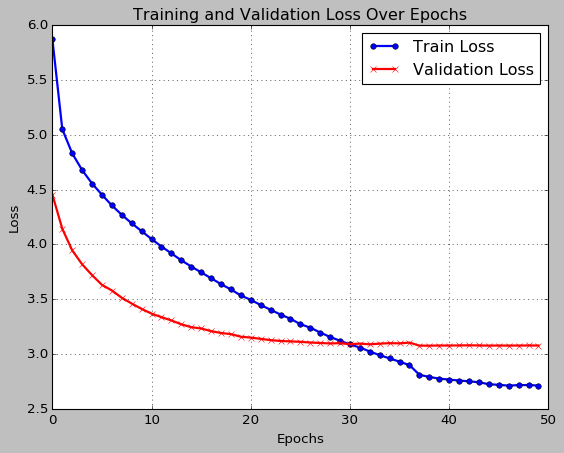

In [31]:
import matplotlib.pyplot as plt

# Use a style template
plt.style.use('classic')

# Create the plot
plt.plot(train_loss, label="Train Loss", color='blue', linewidth=2, marker='o', markersize=5)
plt.plot(valid_loss, label="Validation Loss", color='red', linewidth=2, marker='x', markersize=5)

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')

# Add a legend
plt.legend()

# Add a grid
plt.grid(True)

# Show the plot
plt.show()

In [25]:
torch.save(student_model, '/content/Mydrive/MyDrive/18786 Project/Results/student_model.pth')

In [ ]:
plt.style.available

In [39]:
epoch = 30
student_model = torch.load('/content/Mydrive/MyDrive/18786 Project/Results/student_model.pth')

In [40]:
torch.cuda.empty_cache()
gc.collect()

17

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = torch.optim.AdamW(student_model.parameters(), lr=1e-4)
dataset = CustomDataset("/content/data/train/dialogues_train.txt", tokenizer, 12, 512)
validationset = CustomDataset("/content/data/validation/dialogues_validation.txt", tokenizer, 1, 512)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, threshold=0.001)
trains_loss = []
valids_loss = []
trains_loss_d = []
for i in range(epoch):
    e_loss_1 = 0
    e_loss_2 = 0
    student_model.train()
    teacher_model.eval()
    for data_point in tqdm(dataset.load_batch(), total=dataset.length, leave=True):
        optimizer.zero_grad()
        for j in range(len(data_point)):
            if j == 0:
                x, mask = data_point[j]['input_ids'].to(device), data_point[j]["attention_mask"].to(device)
            else:
                x, mask = torch.cat([x, data_point[j]['input_ids'].to(device)], dim=0), torch.cat([mask, data_point[j]["attention_mask"].to(device)], dim=0)

        src = x[:, :-1]
        tgt = x[:, 1: ]
        bool_mask = ~ mask.to(torch.bool)
        float_mask = bool_mask.to(torch.float)
        float_mask = float_mask.masked_fill(bool_mask, float('-inf'))
        student_logits = student_model(src, float_mask[:, :-1])
        with torch.no_grad():
            teacher_logits = teacher_model(src, mask[:, :-1])

        distillation_losses = distillation_loss(student_logits, teacher_logits)
        loss = distillation_losses
        loss.backward()
        optimizer.step()
        e_loss_1 += primary_loss.item()
        e_loss_2 += distillation_losses.item()

    e_loss_1 = e_loss_1/(dataset.length)
    e_loss_2 = e_loss_2/(dataset.length)
    v_loss = validation(student_model, validationset, criterion)
    print(e_loss_2)
    print(v_loss)
    print('tgts: {}'.format(tokenizer.decode(tgt[0].tolist())))
    print('pred: {}'.format(tokenizer.decode(torch.argmax(student_logits, dim=-1)[0].tolist())))
    print("epoch: {}".format(i))
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {i + 1}, Current Learning Rate: {current_lr}")
    trains_loss_d.append(e_loss_2)
    trains_loss.append(e_loss_1)
    valids_loss.append(v_loss)
    scheduler.step(v_loss)

927it [11:52,  1.30it/s]
100%|██████████| 1000/1000 [01:02<00:00, 16.09it/s]


1492.7235520035351
3.8785242784023284
tgts: Are you free next thursday?  Yeah, why, is there something going on Thursday?  A bunch of us in the office are planning a retiring party for Bob, he's been with the office for ages, so everyone was really surprised to hear he took early retirement.  Bob is retiring, wow... that's news to me, I had no idea Bob was that old, retirement's still sixty-five, right?  Retirement age is still 65, but I think more and more people are retiring earlier, I think Bob's in upper fifties already, he just looks pretty young.  Wow... I thought he was early forty stops, why would he want to retire so soon?  Well, I think you prepare it well and capture good savings, retiring early can give you a lot more time for travel and other activities, you should get out and enjoy the life you still can't, don't you think? 
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

 75%|███████▌  | 696/926 [08:54<02:56,  1.30it/s]